<a href="https://colab.research.google.com/github/ehsanbarkhordar/Bank-Customer-Clustering-By-Transactions/blob/main/Czech_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install scikit-learn-extra
!pip install kneed

In [3]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import SGD
from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn_extra.cluster import KMedoids
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [4]:
from os import listdir
from os.path import isfile, join
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + '/lpetrocelli-retail-banking-demo-data/'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

['CRM Call Center Logs.csv',
 'CRM Events.csv',
 'completedcard.csv',
 'LuxuryLoanPortfolio.csv',
 'completedorder.csv',
 'completedloan.csv',
 'completedclient.csv',
 'completedacct.csv',
 'completedtrans.csv',
 'completeddistrict.csv',
 'CRM Reviews.csv',
 'completeddisposition.csv']

In [5]:
# Import Clients
df_clients = pd.read_csv(dataset_path+'completedclient.csv', index_col=[0], low_memory=False)
# Import Transactions
df_trans = pd.read_csv(dataset_path+'completedtrans.csv', index_col=[0], low_memory=False)
# Import Positions
df_positions = pd.read_csv(dataset_path+'completeddisposition.csv', index_col=[0], low_memory=False)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df_clients = df_clients.join(df_positions.set_index('client_id'), on='client_id')

In [7]:
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,A00011359,Owner


In [8]:
df_clients[['account_id','sex','age','zipcode']]

,account_id,sex,age,zipcode
client_id,,,,
C00000001,A00000001,Female,29,47246
C00000002,A00000002,Male,54,10040
C00000003,A00000002,Female,59,10162
C00000004,A00000003,Male,43,49047
C00000005,A00000003,Female,39,40852
...,...,...,...,...
C00013955,A00011349,Female,54,10121
C00013956,A00011349,Male,56,10118
C00013968,A00011359,Male,31,2721


In [9]:
zip_set=set(df_clients['zipcode'])
zip_list=list(df_clients['zipcode'])
print("all zip codes in dataset: ",len(zip_list))
print("unique zip codes in dataset: ",len(zip_set))

all zip codes in dataset:  5369
unique zip codes in dataset:  3512


In [10]:
df_clients_onehot = pd.DataFrame()

In [11]:
df_clients_onehot['account_id']=df_clients['account_id']

In [12]:
data=list(df_clients['sex'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of sex onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['sex'] = onehot_encoded.tolist()

['Female' 'Male' 'Female' ... 'Male' 'Female' 'Female']
[0 1 0 ... 1 0 0]
shape of sex onehot_encoded:  (5369, 2)


In [13]:
data=list(df_clients['age'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of age onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['age'] = onehot_encoded.tolist()

[29 54 59 ... 31 37 46]
[17 42 47 ... 19 25 34]
shape of age onehot_encoded:  (5369, 77)


In [14]:
data=list(df_clients['zipcode'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of zipcode onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['zipcode'] = onehot_encoded.tolist()

[47246 10040 10162 ...  2721 48475 44244]
[2625  167  211 ...  118 3049 1677]
shape of zipcode onehot_encoded:  (5369, 3512)


In [15]:
df_clients_onehot['static_vector'] = df_clients_onehot.apply (lambda row: np.concatenate([row.sex, row.age, row.zipcode]), axis=1)

In [16]:
df_clients_onehot

,account_id,sex,age,zipcode,static_vector
client_id,,,,,
C00000001,A00000001,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000002,A00000002,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000003,A00000002,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000004,A00000003,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000005,A00000003,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
C00013955,A00011349,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013956,A00011349,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013968,A00011359,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
print("static vector dimention: ",df_clients_onehot.iloc[0]['static_vector'].shape)

static vector dimention:  (3591,)


In [18]:
# Convert date to python datetime
df_trans['fulldate'] = pd.to_datetime(df_trans['fulldate'],format="%Y-%m-%d")
df_trans['timestamp'] = df_trans.fulldate.values.astype(np.int64) // 10 ** 9

In [19]:
df_trans

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [20]:
df_trans = df_trans.sort_values('fulldate')

df_z_scaled = df_trans
df_z_scaled['amount'] = (df_z_scaled['amount'] - df_z_scaled['amount'].mean()) / df_z_scaled['amount'].std()
df_z_scaled['timestamp'] = (df_z_scaled['timestamp'] - df_z_scaled['timestamp'].mean()) / df_z_scaled['timestamp'].std()

df_trans_groupby_account_id = df_z_scaled.groupby(['account_id'])

In [21]:
df_z_scaled

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,-0.548597,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,-2.860870
2,T00171812,A00000576,Credit,Credit in Cash,-0.527595,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,-2.860870
3,T00207264,A00000704,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,-2.860870
4,T01117247,A00003818,Credit,Credit in Cash,-0.559098,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,-2.860870
5,T00579373,A00001972,Credit,Credit in Cash,-0.580101,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,-2.858917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053317,T03629556,A00002990,Credit,NaN,-0.603728,42712.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:14:06,2018-12-31T13:14:06,1.417798
1053316,T03630422,A00003025,Credit,NaN,-0.614345,15933.6,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:31:03,2018-12-31T13:31:03,1.417798
1053315,T03631495,A00003053,Credit,NaN,-0.585372,86982.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,16:53:60,2018-12-31T16:53:60,1.417798
1053321,T03632209,A00003077,Credit,NaN,-0.593973,68530.7,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:55:47,2018-12-31T14:55:47,1.417798


In [22]:
df = df_trans_groupby_account_id
df_trans_groupby_account_id.size()

account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Length: 4500, dtype: int64

In [23]:
# df.groups.keys()

In [24]:
max_length_of_transaction = df['amount'].count().max()
print("max trans lenght is: ", max_length_of_transaction)
df['amount'].count()

max trans lenght is:  675


account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Name: amount, Length: 4500, dtype: int64

In [25]:
df.get_group('A00000001')

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
149432,T00000001,A00000001,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2015,3,24,2015-03-24,10:21:45,2015-03-24T10:21:45,-1.274442
157404,T00000005,A00000001,Credit,Collection from Another Bank,-0.235767,4679.0,NaN,JPMorgan Chase,41403269.0,2015,4,13,2015-04-13,08:54:57,2015-04-13T08:54:57,-1.235367
158832,T00000199,A00000001,Credit,Credit in Cash,0.701044,17279.0,NaN,NaN,NaN,2015,4,23,2015-04-23,10:54:46,2015-04-23T10:54:46,-1.215830
162681,T03530438,A00000001,Credit,NaN,-0.620089,17298.2,Interest Credited,NaN,NaN,2015,4,30,2015-04-30,11:01:59,2015-04-30T11:01:59,-1.202154
167083,T00000006,A00000001,Credit,Collection from Another Bank,-0.235767,20977.2,NaN,JPMorgan Chase,41403269.0,2015,5,13,2015-05-13,10:33:00,2015-05-13T10:33:00,-1.176755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032336,T03530481,A00000001,Credit,NaN,-0.615059,16701.5,Interest Credited,NaN,NaN,2018,11,30,2018-11-30,13:58:35,2018-11-30T13:58:35,1.357232
1033713,T00000230,A00000001,Debit,Cash Withdrawal,-0.149552,12186.9,NaN,NaN,NaN,2018,12,3,2018-12-03,13:09:19,2018-12-03T13:09:19,1.363094
1035097,T00000097,A00000001,Debit,Remittance to Another Bank,-0.364616,9734.9,Household,State Street Corp.,87144583.0,2018,12,5,2018-12-05,11:42:20,2018-12-05T11:42:20,1.367001
1045493,T00000049,A00000001,Credit,Collection from Another Bank,-0.235767,13413.9,NaN,JPMorgan Chase,41403269.0,2018,12,13,2018-12-13,14:00:08,2018-12-13T14:00:08,1.382631


In [26]:
sequence_input_list = []
sequence_output_list = []

for k, v in df_trans.groupby('account_id'):
  user_trans_array = pd.concat([v.amount, v.timestamp], axis=1).values
  array = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1, -1], axis=0)
  input_array = np.append(add_start_to_array, [[-2, -2]], axis=0)
  output_array = np.append(array, [[-2, -2]], axis=0)
  # resize array to max_lenght
  input_array.resize((max_length_of_transaction,2), refcheck=False)
  output_array.resize((max_length_of_transaction,2), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)

In [27]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
sequence_output_array.shape

(4500, 675, 2)

In [28]:
(sequence_output_input_array == sequence_output_array).all()

False

In [29]:
# Build static input array
list_of_account_ids = list(df.groups.keys())
static_input_list = []
for account_id in list_of_account_ids:
  sub_df = df_clients_onehot.loc[df_clients_onehot['account_id'] == account_id]
  account_static_vector = sub_df.iloc[0]['static_vector']
  static_input_list.append(account_static_vector)
static_input_array = np.array(static_input_list)
print(static_input_array.shape)
static_output_array = static_input_array
static_input_array

(4500, 3591)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [30]:
latent_dim = 128
decoder_dim = 2
###########################################  encoder  ###########################################

# Sequence input shape is N*2 which N is sequence length and 2 is price and time
sequence_input = Input(name='sequence_input', shape=(None, 2))

# Many_to_one_lstm
outputs  = LSTM(2048, return_sequences=True)(sequence_input)
outputs = GRU(1024, return_sequences=True)(outputs)
# outputs = Dropout(0.2, input_shape=(2,))(outputs)
encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

latent_space = Concatenate()([hidden_state, cell_state])
#Layer below output can be used for clustering purposes
latent_space = Dense(latent_dim, activation = 'elu', name='latent_space')(latent_space)

In [31]:
###########################################  decoder  ###########################################

# Temporary input with a time step delay for producing sequence output
# This input is exacly similar to sequence_input with only this diffrence that has a time step delay
sequence_output_input = Input(name='sequence_output_input', shape=(None, 2))

# One to many GRU (because of its simplicity, we used GRU instead of LSTM)
decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input,
                                                         initial_state = latent_space)
###########################################  attention  ###########################################
attention = dot([decoder_out, encoder_out], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_out], axes=[2,1])
decoder_combined_context = Concatenate()([context, decoder_out])
###########################################  /attention  ###########################################

decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_combined_context)

###########################################  /decoder  ###########################################

# Model has three inputs and 2 outputs (last input is temorary)
model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

model.compile(
    optimizer="adam", loss=["mse", "mse"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 2048)   16801792    sequence_input[0][0]             
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 1024)   9443328     lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  590336      gru[0][0]                        
______________________________________________________________________________________________

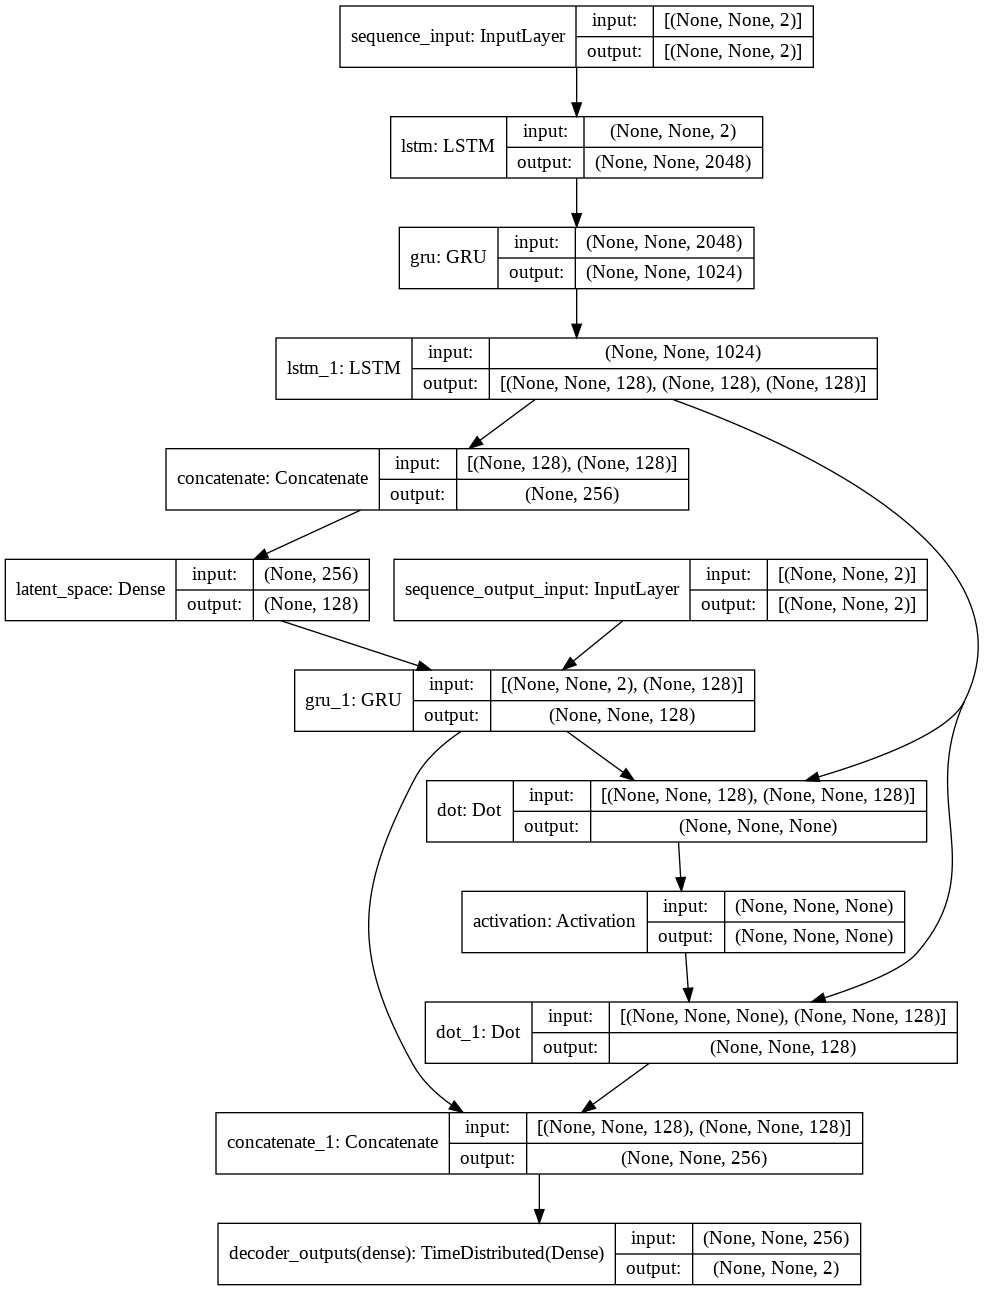

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(sequence_input_array, sequence_output_array, test_size=0.20, random_state=42)

In [34]:
# fit the keras model on the dataset
batch_size = 128
inputs = [X_train, X_train]
outputs = [y_train]
model.fit(inputs, outputs, epochs=5, batch_size = batch_size, validation_split=0.1)

Epoch 1/5
26/26 [==============================] - 125s 5s/step - loss: 0.4386 - val_loss: 0.3628
Epoch 2/5
26/26 [==============================] - 125s 5s/step - loss: 0.3548 - val_loss: 0.3628
Epoch 3/5
26/26 [==============================] - 124s 5s/step - loss: 0.3581 - val_loss: 0.3628
Epoch 4/5
26/26 [==============================] - 124s 5s/step - loss: 0.3579 - val_loss: 0.3628
Epoch 5/5
26/26 [==============================] - 125s 5s/step - loss: 0.3540 - val_loss: 0.3628


In [35]:
# save the model to disk
# model.save(my_drive_path)

In [36]:
# load model
# model = keras.models.load_model(my_drive_path)

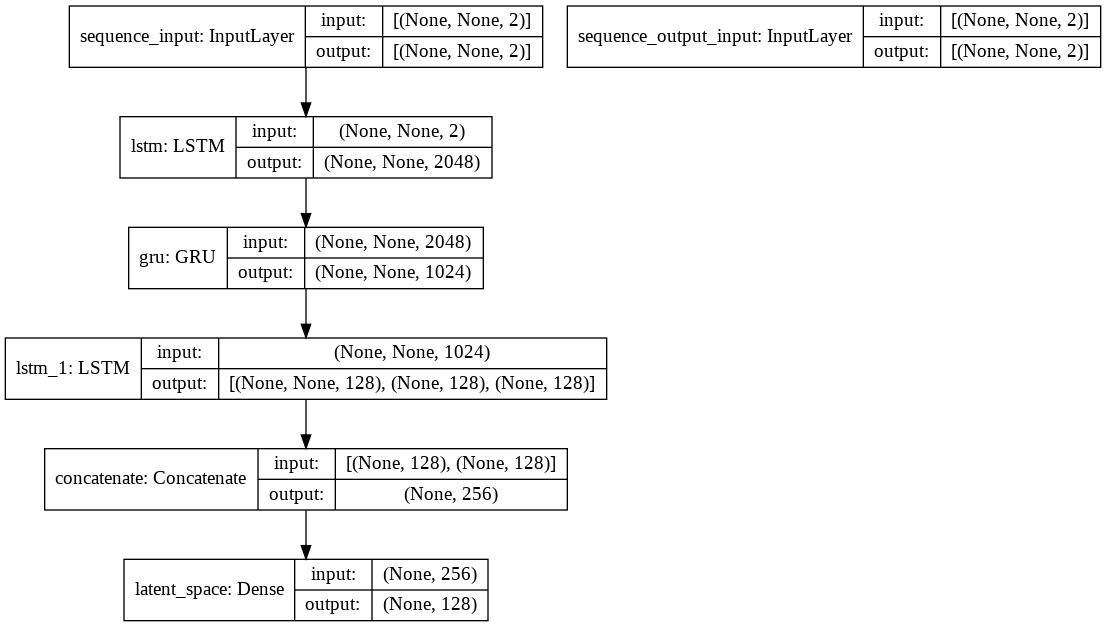

In [37]:
encoder = Model( model.input , model.get_layer("latent_space").output)
plot_model(encoder, show_shapes=True, show_layer_names=True)

In [38]:
x = [sequence_input_array, sequence_output_input_array]
predictions = encoder.predict(x, batch_size = batch_size)

In [39]:
print(predictions.shape)
predictions

(4500, 128)


array([[161.41406 ,  -1.      ,  -1.      , ..., 165.13615 ,  -1.      ,
        121.80074 ],
       [161.53198 ,  -1.      ,  -1.      , ..., 165.3058  ,  -1.      ,
        121.665665],
       [161.27281 ,  -1.      ,  -1.      , ..., 164.89238 ,  -1.      ,
        121.97781 ],
       ...,
       [161.46365 ,  -1.      ,  -1.      , ..., 165.19    ,  -1.      ,
        121.76015 ],
       [161.39726 ,  -1.      ,  -1.      , ..., 165.08873 ,  -1.      ,
        121.835205],
       [161.41951 ,  -1.      ,  -1.      , ..., 165.10751 ,  -1.      ,
        121.82214 ]], dtype=float32)

In [40]:
standard_x = StandardScaler().fit_transform(predictions)
standard_x

array([[ 1.9511321e-01,  0.0000000e+00,  0.0000000e+00, ...,
         3.2785374e-01,  0.0000000e+00, -2.9145736e-01],
       [ 1.5657078e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.5021368e+00,  0.0000000e+00, -1.5371066e+00],
       [-1.4466562e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.3595313e+00,  0.0000000e+00,  1.3414302e+00],
       ...,
       [ 7.7151489e-01,  0.0000000e+00,  0.0000000e+00, ...,
         7.0058668e-01,  0.0000000e+00, -6.6582054e-01],
       [-1.5394359e-04,  0.0000000e+00,  0.0000000e+00, ...,
        -4.1320888e-04,  0.0000000e+00,  2.6339754e-02],
       [ 2.5842872e-01,  0.0000000e+00,  0.0000000e+00, ...,
         1.2960501e-01,  0.0000000e+00, -9.4109364e-02]], dtype=float32)

In [41]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(standard_x)

In [42]:
principal_components

array([[  1.7341555 ,  -1.7959423 ,  -1.057377  ],
       [ 12.235277  ,   0.56859106,   0.66152614],
       [-10.971109  ,  -1.3350393 ,   0.8649128 ],
       ...,
       [  5.9585223 ,   1.5646777 ,  -0.02570878],
       [ -0.20528774,   0.13088103,  -0.93452764],
       [  1.267845  ,   2.344317  ,  -1.2029116 ]], dtype=float32)

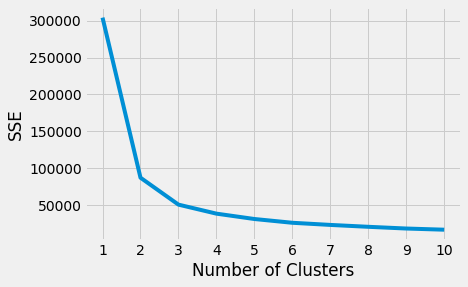

In [43]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [44]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [45]:
kmeans = KMeans(n_clusters= kl.elbow, **kmeans_kwargs)
kmeans.fit(principal_components)
kmeans.labels_

array([2, 0, 1, ..., 0, 2, 2], dtype=int32)

In [46]:
set(kmeans.labels_)

{0, 1, 2}

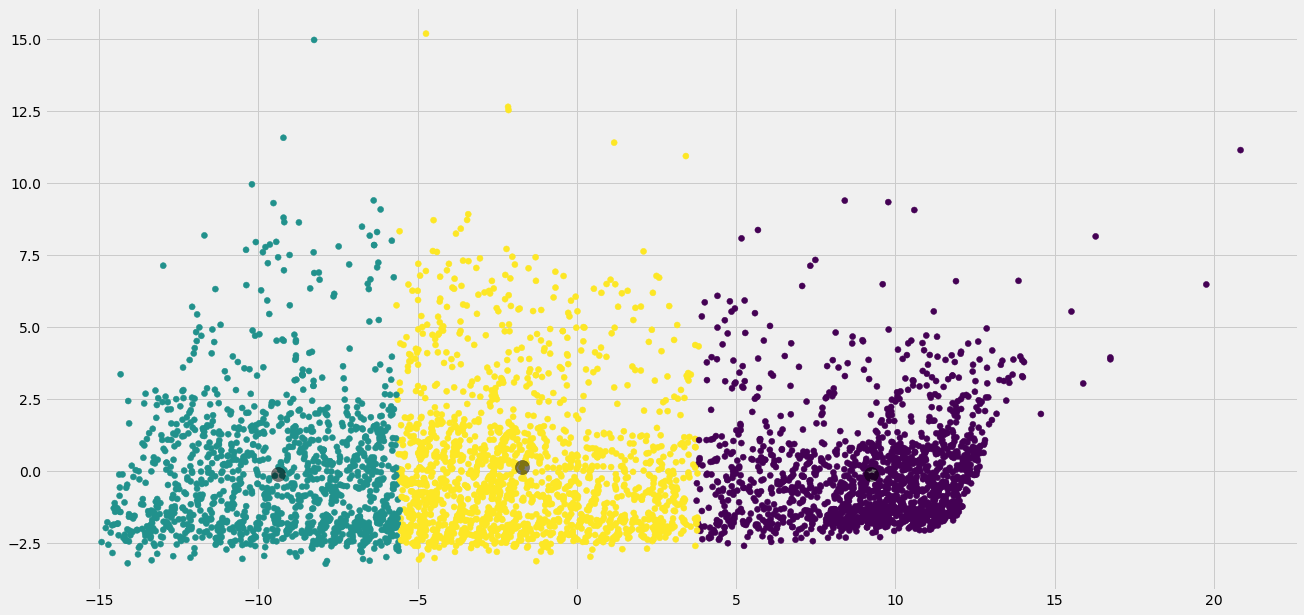

In [47]:
fig = plt.figure(figsize=(20,10))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

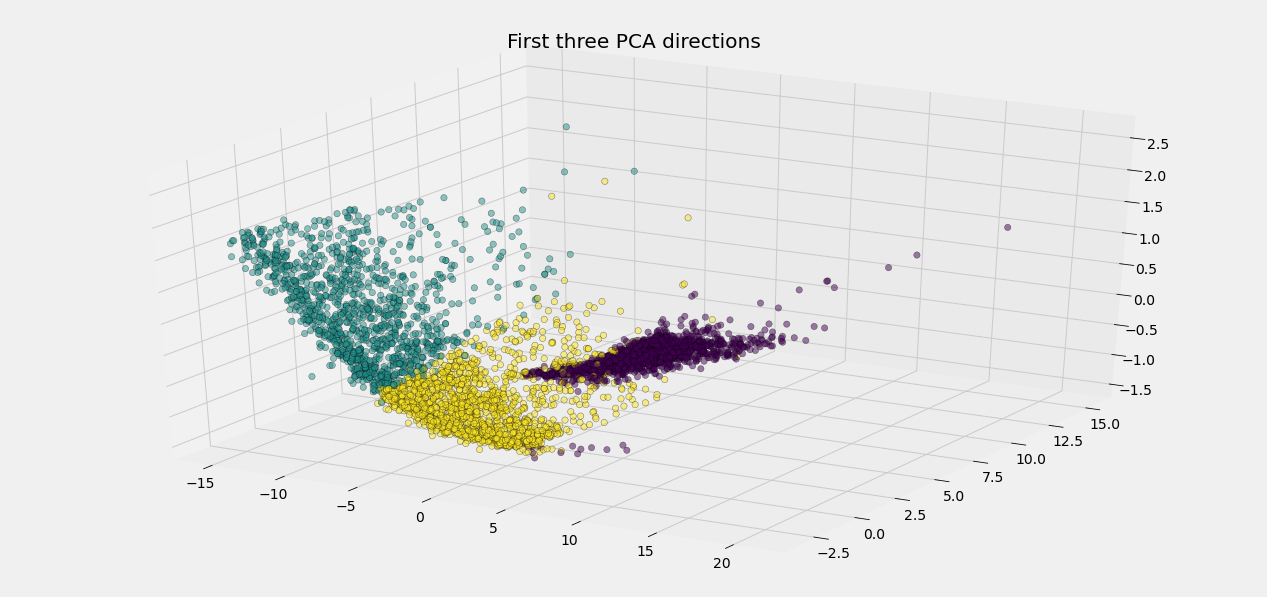

In [48]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:,0],principal_components[:,1],principal_components[:,2], 
            c=kmeans.labels_, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)
ax.set_title("First three PCA directions")
ax.dist = 10

In [49]:
kmedoids = KMedoids(n_clusters = kl.elbow, random_state=0).fit(principal_components)
kmedoids.labels_

array([0, 2, 1, ..., 2, 0, 0])

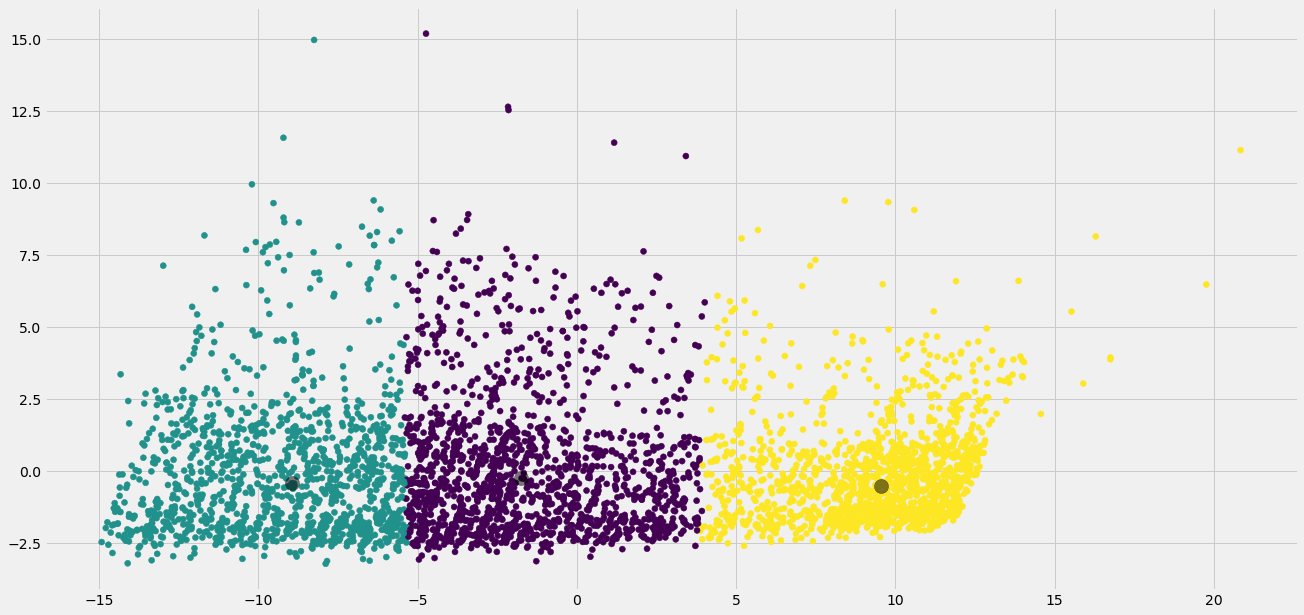

In [50]:
fig = plt.figure(figsize=(20,10))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmedoids.labels_)
centers = kmedoids.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

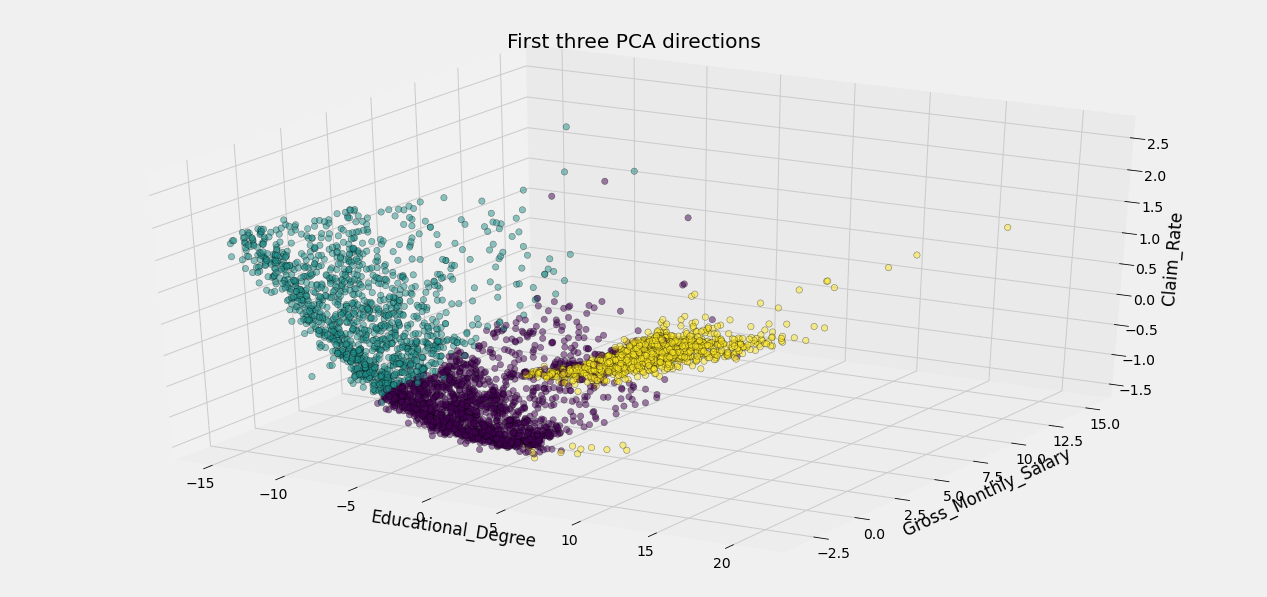

In [51]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:,0],principal_components[:,1],principal_components[:,2], 
            c=kmedoids.labels_, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)


ax.set_title("First three PCA directions")
ax.set_xlabel("Educational_Degree")
ax.set_ylabel("Gross_Monthly_Salary")
ax.set_zlabel("Claim_Rate")
ax.dist = 10

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.60124135
For n_clusters = 3 The average silhouette_score is : 0.5101304
For n_clusters = 4 The average silhouette_score is : 0.45948887
For n_clusters = 5 The average silhouette_score is : 0.4759236
For n_clusters = 6 The average silhouette_score is : 0.42906484


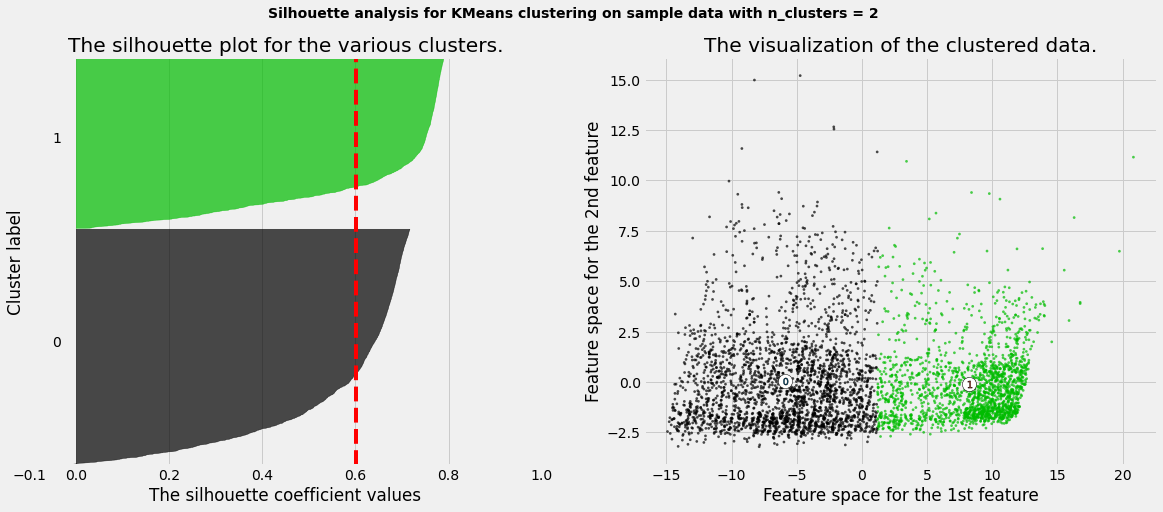

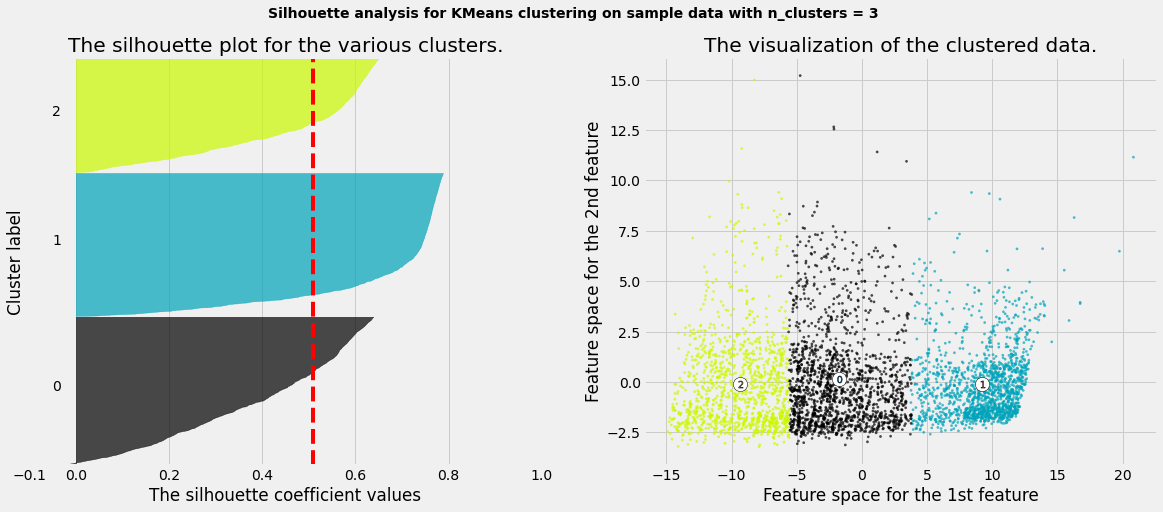

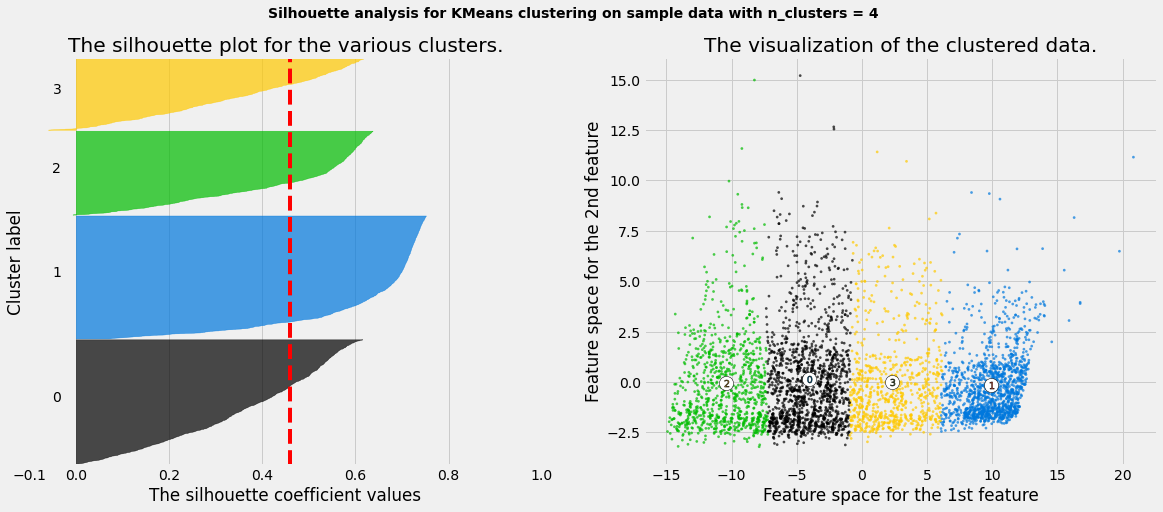

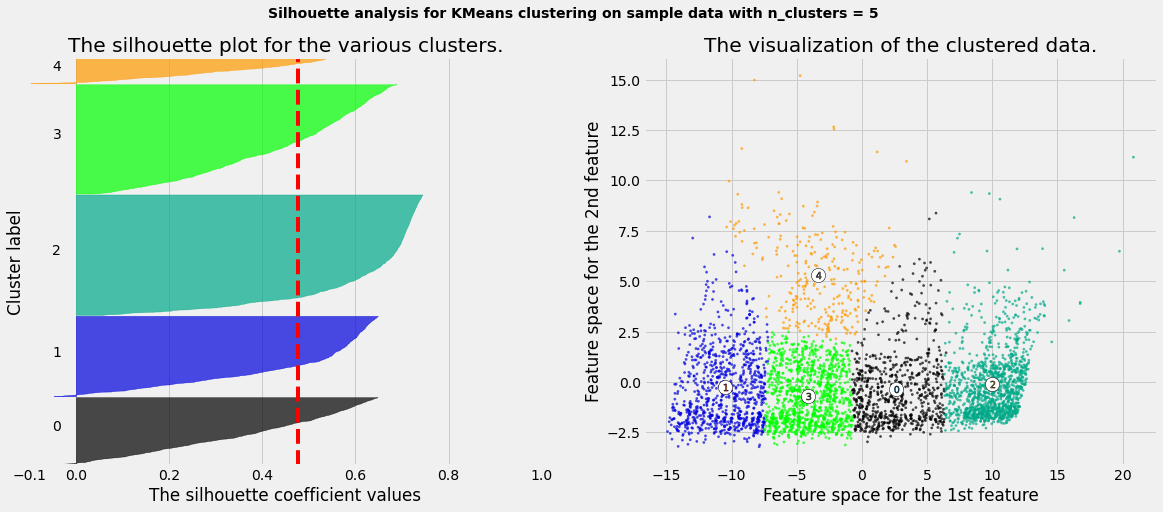

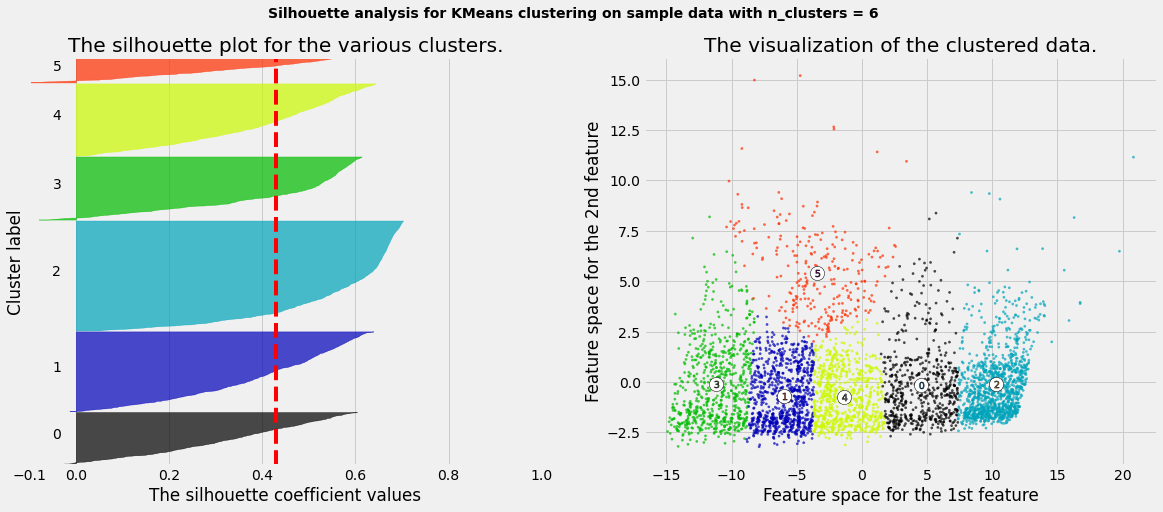

In [52]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility
X = principal_components
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
